## Training Section

### Preprocess   

* TFs --- TF with condition values as row
* Genes -- genes to fit data

In [1]:
import numpy as np

In [2]:
dataset = np.genfromtxt ('dataset/expression/KO.txt',dtype=None,  skip_header=1)

C:\Users\tonyt\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [3]:
TF_names = np.genfromtxt ('dataset/expression/KO_TF_names.txt',dtype=None,usecols=[0])

C:\Users\tonyt\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [4]:
TF_names_set = set(TF_names)

In [6]:
Genes,TFs = [], []
for row in dataset:
    if row[0] in TF_names_set:
        TFs.append(row)
    else:
        Genes.append(row)
Genes = np.array(Genes)
TFs = np.array(TFs)

### LASSO Regression

## Evaluation Section

## GENIE3

### The inferred result from our method:

In [7]:
inferred_result = np.genfromtxt('dataset/inferred/GENIE3.KO.txt', names=['gene_a','gene_b','confidence'], dtype=None)

C:\Users\tonyt\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [8]:
all_possible_pairs = np.genfromtxt('dataset/inferred/GENIE3.KO.txt', names=['gene_a','gene_b'], dtype=None,usecols=(0,1))

C:\Users\tonyt\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [9]:
inferred_result_binary = np.genfromtxt('dataset/inferred/GENIE3.KO.txt',usecols=(2)).flatten()

### The ground truth:

In [10]:
gold_standard = np.genfromtxt('dataset/gold/MacIsaac2.KO.txt',names=['gene_a','gene_b'],dtype=None)

C:\Users\tonyt\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [11]:
gold_standard_set = set([ e[0]+e[1] for e in gold_standard]).union(set([ e[1]+e[0] for e in gold_standard]))

In [12]:
def in_array(e,gold_standard_set):
    if e[0]+e[1] in gold_standard_set:
        return True
    return False

In [13]:
def match_array(e,gold_standard_set):
    if in_array(e,gold_standard_set):
        return 1
    else:
        return 0

In [14]:
gold_standard_binary = np.array([match_array(e,gold_standard_set) for e in all_possible_pairs])

### auc roc:

In [15]:
from sklearn import metrics

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(gold_standard_binary, inferred_result_binary)

In [17]:
auc = metrics.roc_auc_score(gold_standard_binary, inferred_result_binary)

In [18]:
import matplotlib.pyplot as plt

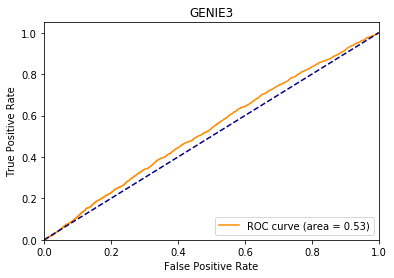

In [19]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
        label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GENIE3')
plt.legend(loc="lower right")
plt.show()